In [127]:
import jax
from jax import grad, jit, lax, random, vmap
from jax.experimental.ode import odeint
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evofr as ef

In [128]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from ode_models import two_variant_model

In [175]:
# Simulate two two-variant systems

## Defining model parameters
R0_wt = 1.5 # Basic reproduction number in wild type

gen_wt = 4.8 # Average length of infection (days): 1 / gam_wt
eta_T = 1.3 # Transmissibility increase
eta_E = 0.9 # Escape fraction 

# Derive corresponding immunity fraction 
def critical_proportion(eta_T, eta_E):
    return (eta_T - 1) / (eta_E + eta_T-1)

phi_crit = critical_proportion(eta_T, eta_E)

# Rest of quantities can be computed from the above
gam_wt =  1 / gen_wt
beta_wt = R0_wt * gam_wt

print("Critical proportion with wildtype immunity:", phi_crit)

Critical proportion with wildtype immunity: 0.25


In [246]:
#####  Defining parameters and initial conditions
true_θ_escape = (beta_wt, gam_wt, 1.0, eta_E, 1.0)
true_θ_transmiss = (beta_wt, gam_wt, eta_T, 0.0, 1.0)

# Simulation
max_time = 365.
initial_prev_wt, initial_prev_var = 1e-5, 1e-8

# Simulate escape variant 
# S0, I_wt, I_ve, R_wt, R_ve, Inc_wt, Inc_ve
u0E = jnp.array([1 - phi_crit, initial_prev_wt, initial_prev_var, phi_crit, 0.0, 0.0, 0.0])
t = jnp.arange(max_time)
YE = odeint(two_variant_model, u0E, t, true_θ_escape)

# Simulate transmissibility variant 
# S0, I_wt, I_vt, R_wt, R_vt, Inc_wt, Inc_vt
u0T = jnp.array([1-phi_crit, initial_prev_wt, initial_prev_var, phi_crit, 0.0, 0.0, 0.0])
t = jnp.arange(max_time)
YT = odeint(two_variant_model, u0T, t, true_θ_transmiss)

I_wtE, I_ve, phi_wtE = YE[:, 1], YE[:, 2], YE[:, 3]
ST, I_wtT, I_vt = YT[:, 0], YT[:, 1], YT[:, 2]

In [247]:
PRES_PATH = "../manuscript/figures/"

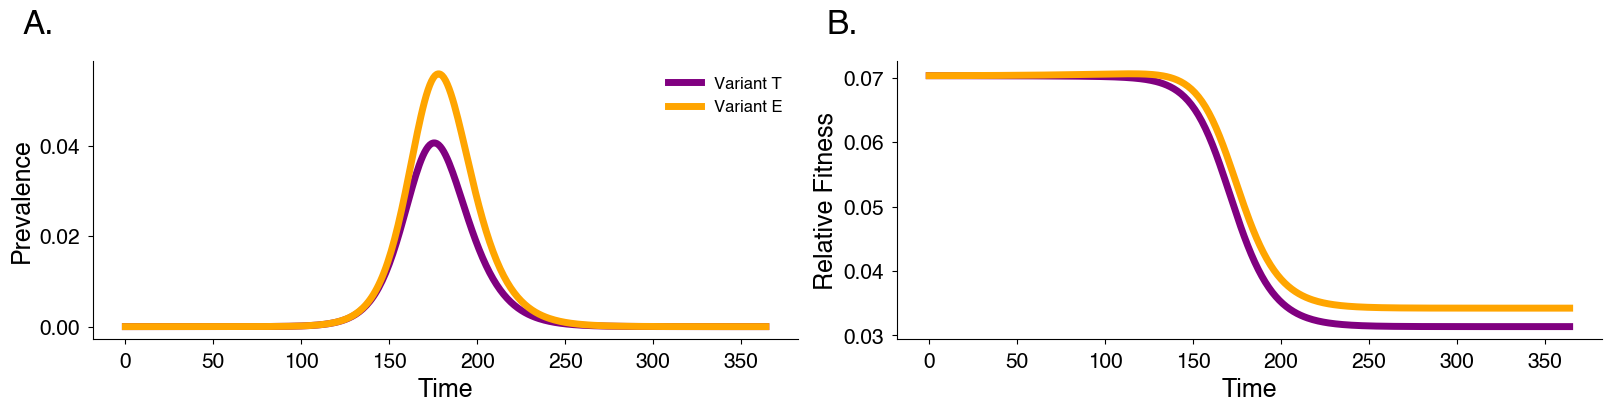

In [290]:
# Show prevalance, epidemic growth rate
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

fig = plt.figure(figsize=(16., 4.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1.0, 1.0])

# Plotting prevalence
ax_prev = fig.add_subplot(spec[0, 0])
ax_prev.plot(I_vt, color=VART_COLOR, label=VART_LABEL)
ax_prev.plot(I_ve, color=VARE_COLOR, label=VARE_LABEL)

ax_prev.set_ylabel("Prevalence")
ax_prev.set_xlabel("Time")
ax_prev.legend(frameon=False)


# Plotting epidemic growth rate
def egr(Y):
    return jnp.diff(jnp.log(Y), prepend=jnp.nan)
    
ax_egr = fig.add_subplot(spec[0, 1])

relative_fitness_T = (eta_T - 1) * beta_wt * ST
ax_egr.plot(relative_fitness_T, color=VART_COLOR)

relative_fitness_E = eta_E * beta_wt * phi_wtE
ax_egr.plot(relative_fitness_E, color=VARE_COLOR)

ax_egr.set_ylabel("Relative Fitness")
ax_egr.set_xlabel("Time")

# Plotting sources
#ax_source = fig.add_subplot(spec[1, 0])
#ax_source.plot(ST)
#ax_source.set_ylabel("Proportion susceptible\n (T simulation)")

#ax_source = fig.add_subplot(spec[1, 1])
#ax_source.plot(phi_wtE)
#ax_source.set_ylabel("Proportion with wildtype exposure")

import string
axes = [ax_prev, ax_egr]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=24, weight='bold')
    
# What to show estimated relative fitness is initially identical?
# OR show how selective pressure differs

# Can we show why this is different?

# Consider derivatives of relative_fitneses!
# This is because there is slight growth in wildtype immune population due to co-circulation of wildtype

In [315]:
# Difference in cummulative incidence as a function of initial wt frequency
def simulate(true_θ_escape, true_θ_transmiss, initial_prev_wt=1e-5, initial_prev_var=1e-8):
    # Simulation
    max_time = 365.
    
    # Simulate escape variant 
    # S0, I_wt, I_ve, R_wt, R_ve, Inc_wt, Inc_ve
    u0E = jnp.array([1 - phi_crit, initial_prev_wt, initial_prev_var, phi_crit, 0.0, 0.0, 0.0])
    t = jnp.arange(max_time)
    YE = odeint(two_variant_model, u0E, t, true_θ_escape)

    # Simulate transmissibility variant 
    # S0, I_wt, I_vt, R_wt, R_vt, Inc_wt, Inc_vt
    u0T = jnp.array([1-phi_crit, initial_prev_wt, initial_prev_var, phi_crit, 0.0, 0.0, 0.0])
    t = jnp.arange(max_time)
    YT = odeint(two_variant_model, u0T, t, true_θ_transmiss)
    return YE, YT

def compute_incidence_difference(YE, YT):
    Inc_ve = YE[:, -1]
    Inc_vt = YT[:, -1]
    return (Inc_ve - Inc_vt)[-1]

def compute_incidence_wt_E(YE, YT):
    Inc_wt_E = YE[:, -2]
    Inc_vt = YT[:, -1]
    return Inc_wt_E[-1]


initial_prev_wt_vec = np.power(10, np.arange(-8., -2., 0.5))

inc_diffs = []
inc_wt_E = []
for initial_prev_wt_ in initial_prev_wt_vec:
    YE_, YT_ = simulate(true_θ_escape, true_θ_transmiss, initial_prev_wt_, initial_prev_var)
    inc_diffs.append(
        compute_incidence_difference(YE_, YT_)
    )
    inc_wt_E.append(
        compute_incidence_wt_E(YE_, YT_)
    )

    
inc_diffs = jnp.vstack(inc_diffs)

Text(0, 0.5, '$\\Delta$ cummulative incidence\n (Escape - Transmissibility)')

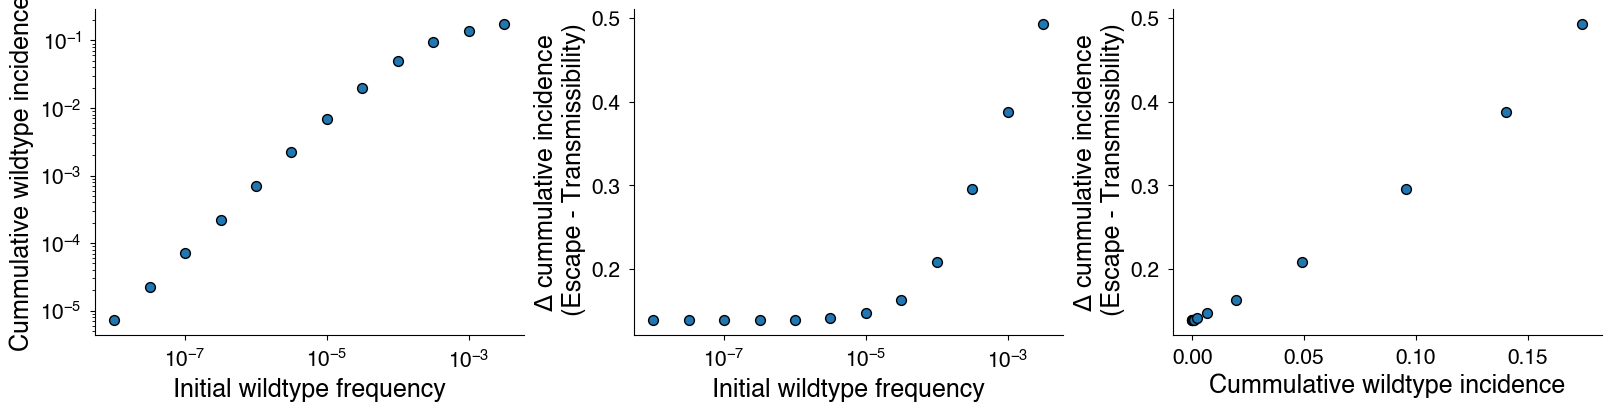

In [337]:
fig = plt.figure(figsize=(16., 4.), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=1)

ax_inc_diff = fig.add_subplot(spec[0])
ax_inc_diff.scatter(initial_prev_wt_vec, inc_wt_E, ec="k", s=50)
ax_inc_diff.set_xscale("log", base=10)
ax_inc_diff.set_yscale("log", base=10)
ax_inc_diff.set_xlabel("Initial wildtype frequency")
ax_inc_diff.set_ylabel("Cummulative wildtype incidence")

ax_inc_diff = fig.add_subplot(spec[1])
ax_inc_diff.scatter(initial_prev_wt_vec, inc_diffs, ec="k", s=50)
ax_inc_diff.set_xscale("log", base=10)
ax_inc_diff.set_xlabel("Initial wildtype frequency")
ax_inc_diff.set_ylabel(r"$\Delta$ cummulative incidence" + "\n (Escape - Transmissibility)")


ax_inc_diff = fig.add_subplot(spec[2])
ax_inc_diff.scatter(inc_wt_E, inc_diffs , ec="k", s=50)
ax_inc_diff.set_xlabel("Cummulative wildtype incidence")
ax_inc_diff.set_ylabel(r"$\Delta$ cummulative incidence" + "\n (Escape - Transmissibility)")

# Use 1 + 3

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_1281/3300246309.py:55: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


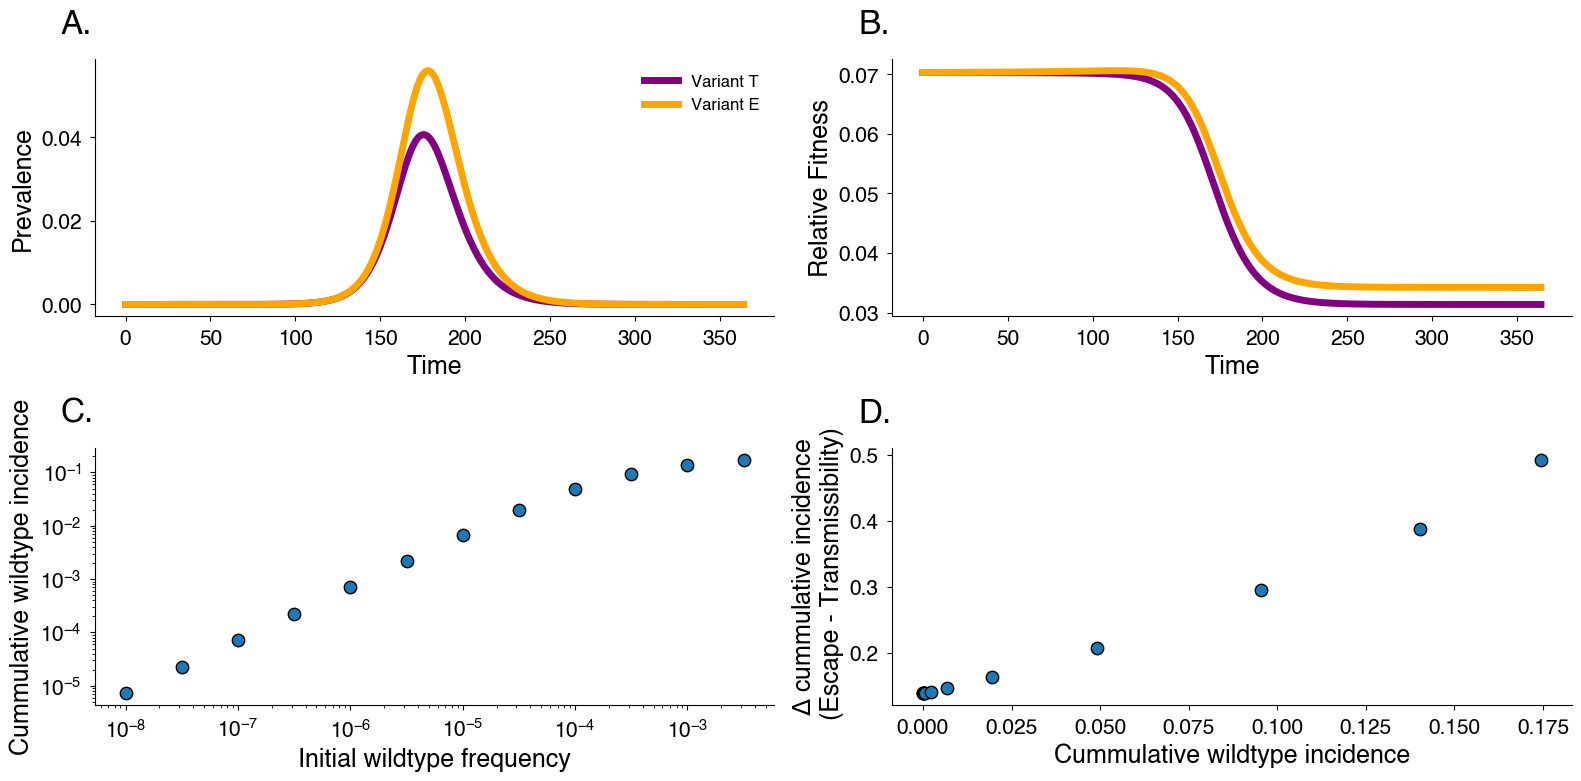

In [351]:
# Show prevalance, epidemic growth rate
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

fig = plt.figure(figsize=(16., 8.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.0, 1.0])

# Plotting prevalence
ax_prev = fig.add_subplot(spec[0, 0])
ax_prev.plot(I_vt, color=VART_COLOR, label=VART_LABEL)
ax_prev.plot(I_ve, color=VARE_COLOR, label=VARE_LABEL)

ax_prev.set_ylabel("Prevalence")
ax_prev.set_xlabel("Time")
ax_prev.legend(frameon=False)


# Plotting epidemic growth rate
def egr(Y):
    return jnp.diff(jnp.log(Y), prepend=jnp.nan)
    
ax_egr = fig.add_subplot(spec[0, 1])

relative_fitness_T = (eta_T - 1) * beta_wt * ST
ax_egr.plot(relative_fitness_T, color=VART_COLOR)

relative_fitness_E = eta_E * beta_wt * phi_wtE
ax_egr.plot(relative_fitness_E, color=VARE_COLOR)

ax_egr.set_ylabel("Relative Fitness")
ax_egr.set_xlabel("Time")

# Plotting effect of changing initial wildtype frequency
ax_init_freq_inc_diff = fig.add_subplot(spec[1, 0])
ax_init_freq_inc_diff.scatter(initial_prev_wt_vec, inc_wt_E, ec="k", s=80)
ax_init_freq_inc_diff.set_xscale("log", base=10)
ax_init_freq_inc_diff.set_yscale("log", base=10)
ax_init_freq_inc_diff.set_xlabel("Initial wildtype frequency")
ax_init_freq_inc_diff.set_ylabel("Cummulative wildtype incidence")


ax_inc_wt_inc_diff = fig.add_subplot(spec[1, 1])
ax_inc_wt_inc_diff.scatter(inc_wt_E, inc_diffs , ec="k", s=80)
ax_inc_wt_inc_diff.set_xlabel("Cummulative wildtype incidence")
ax_inc_wt_inc_diff.set_ylabel(r"$\Delta$ cummulative incidence" + "\n (Escape - Transmissibility)")

import string
axes = [ax_prev, ax_egr, ax_init_freq_inc_diff, ax_inc_wt_inc_diff]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.05, 1.1, ax_label + ".", transform=ax.transAxes, size=24, weight='bold')    
    
fig.tight_layout()
fig.savefig("../manuscript/figures/short_term_divergence.png")

In [ ]:
# We could show this same phenomonen through increasing R0?